In [87]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


#data processing
import re, string
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB



#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42


In [88]:
df = pd.read_csv('/kaggle/input/corona-dataset/Corona_NLP_train.csv',encoding='ISO-8859-1')
df_test = pd.read_csv('/kaggle/input/corona-dataset/Corona_NLP_test.csv')

In [89]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [91]:
df['TweetAt'] = pd.to_datetime(df['TweetAt'])

/tmp/ipykernel_43/1259316306.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['TweetAt'] = pd.to_datetime(df['TweetAt'])


In [92]:
df.drop_duplicates(subset='OriginalTweet',inplace=True)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.9+ MB


In [94]:
tweets_per_day = df['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

In [95]:
tweets_per_country = df['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')

In [96]:
df = df[['OriginalTweet','Sentiment']]

In [97]:
df_test = df_test[['OriginalTweet','Sentiment']]

In [98]:
!pip install demoji
import demoji



# Clean emojis from text using the demoji library
def strip_emoji(text):
    return demoji.replace(text, '')

# Remove punctuations, links, mentions, and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()  # Remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', r'', text)  # Remove non utf8/ascii characters
    banned_list = string.punctuation + 'Ã' + '±' + 'ã' + '¼' + 'â' + '»' + '§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))  # Remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))  # Remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

# Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) or ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+", " ", text)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [99]:
texts_new = []
for t in df.OriginalTweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))


# Now, texts_new contains the cleaned tweets


In [100]:
texts_new_test = []
for t in df_test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [101]:
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [102]:
df['text_clean'].head()

0                                              and and
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
Name: text_clean, dtype: object

In [103]:
df_test['text_clean'].head()

0    trending new yorkers encounter empty supermark...
1    when i couldnt find hand sanitizer at fred mey...
2    find out how you can protect yourself and love...
3    panic buying hits newyork city as anxious shop...
4    toiletpaper dunnypaper coronavirus coronavirus...
Name: text_clean, dtype: object

In [104]:
df['text_clean'][1:8].values

array(['advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order',
       'coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid19 outbreak',
       'my food stock is not the only one which is empty please dont panic there will be enough food for everyone if you do not take more than you need stay calm stay safe covid19france covid19 covid19 coronavirus confinement confinementotal confinementgeneral',
       'me ready to go at supermarket during the covid19 outbreak not because im paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please dont panic it causes shortage coronavirusfrance restezchezvous stayathome confinement',
       'as news of the regions first confirmed covid19 case came out of sullivan county last week people 

In [105]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [106]:
df['text_len'] = text_len

In [107]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [108]:
df_test['text_len'] = text_len_test

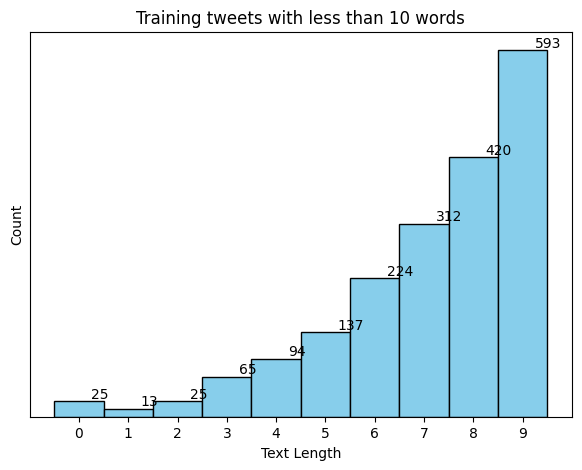

In [109]:

plt.figure(figsize=(7, 5))

# Filter the DataFrame for text lengths less than 10
filtered_df = df[df['text_len'] < 10]

# Create a histogram using Matplotlib
counts, bins, _ = plt.hist(filtered_df['text_len'], bins=range(11), color='skyblue', edgecolor='black', align='left')

# Add labels and title
plt.title('Training tweets with less than 10 words')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.xticks(bins[:-1])  # Set x-axis ticks to bin edges
plt.yticks([])

# Add count labels on top of the bars
for count, bin_edge in zip(counts, bins[:-1]):
    plt.text(bin_edge + 0.25, count, str(int(count)), va='bottom')

plt.show()

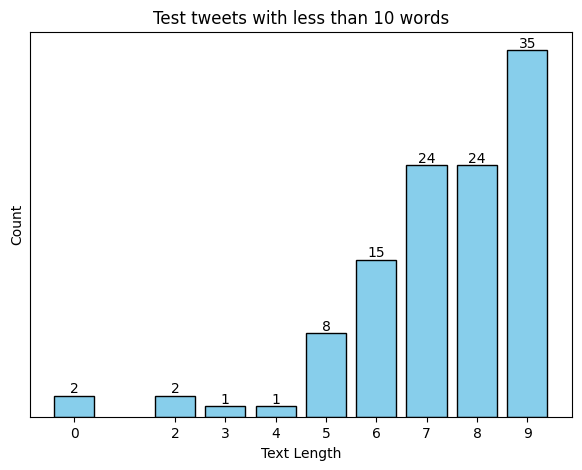

In [110]:

plt.figure(figsize=(7, 5))

# Filter the DataFrame for text lengths less than 10
filtered_df_test = df_test[df_test['text_len'] < 10]

# Create a bar plot using Matplotlib
ax = plt.bar(filtered_df_test['text_len'].value_counts().sort_index().index,
             filtered_df_test['text_len'].value_counts().sort_index(), color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Test tweets with less than 10 words')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.xticks(filtered_df_test['text_len'].value_counts().sort_index().index)
plt.yticks([])

# Add count labels on top of the bars
for bar in ax:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, int(height), ha='center', va='bottom')

plt.show()

In [111]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (41157, 4)
 DF TEST SHAPE: (3798, 4)


In [112]:
df = df[df['text_len'] > 4]

In [113]:
df_test = df_test[df_test['text_len'] > 4]

In [114]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (40935, 4)
 DF TEST SHAPE: (3792, 4)


In [115]:
!pip install sentencepiece
import sentencepiece as spm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [116]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("susnato/ernie-m-base_pytorch")

tokenizer_config.json:   0%|          | 0.00/219 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [117]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

In [118]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 86


In [119]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 7562, TEXT: the dominos fall coronavirus gt world healthemergency gt consumer and supplychain resources shut down gt economy stalls gt credit cracks cc gt liquidity shock ls gt unemployment gt 2x cc gt ls gt spx and bonds crash sbc gt 3x 1 sbc 2xccgtls dominos


In [120]:
df['token_lens'] = token_lens

In [121]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
7600,The dominos fall: #coronavirus &gt; world #h...,Extremely Positive,the dominos fall coronavirus gt world healthem...,44,86
4844,Impct of #coronavirus i hve sen hw civilizd pp...,Extremely Negative,impct of coronavirus i hve sen hw civilizd ppl...,48,80
11106,Which global recession? V or U or L or I? For ...,Negative,which global recession v or u or l or i for no...,64,78
30206,#LDA City Lahore Residential Files Prices Upda...,Neutral,lda city lahore residential files prices updat...,43,78
23019,4 arrested in Koboko (northern #Uganda) for hi...,Negative,4 arrested in koboko northern uganda for hikin...,50,78
37156,11 Nisan Cumartesi itibariyle ?BBÂnin tÃ¼m hi...,Neutral,11 nisan cumartesi itibariyle bbnin tm hizmetl...,39,77
21439,How can US oil rigs not drop hugely? Dallas Fe...,Extremely Positive,how can us oil rigs not drop hugely dallas fed...,52,77
12389,"Okay, so I just checked the drug prices for #P...",Positive,okay so i just checked the drug prices for pla...,35,77
9238,Hi @Zomato I felt hungry loggd in ur app tryd ...,Extremely Positive,hi i felt hungry loggd in ur app tryd to add 4...,55,77
1638,ZÃ¡sah policie proti spekulant?m s rouÂkami. ...,Neutral,zsah policie proti spekulantm s roukami na mj ...,39,76


In [122]:
df = df.iloc[12:]
df.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
25975,#covid-19 #Isolation how on earth will you as...,Extremely Negative,covid19 isolation how on earth will you ask us...,57,76
35384,Safest Job in America is #Uninsured #SuperMark...,Extremely Positive,safest job in america is uninsured supermarket...,39,75
35866,MDOC Horhn MS65 50 MS brown MISSISSIPPI PRISON...,Extremely Negative,mdoc horhn ms65 50 ms brown mississippi prison...,51,75
14582,hiked prices in the face of the Covid-19 crise...,Negative,hiked prices in the face of the covid19 crises...,47,75
28899,Kindly contact Us bamy global merchandise for ...,Positive,kindly contact us bamy global merchandise for ...,37,75


In [123]:
df = df.sample(frac=1).reset_index(drop=True)

In [124]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))

max_len=np.max(token_lens_test)

In [125]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 94


In [126]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 286, TEXT: so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to buy some food to stock txnid093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7f my b
INDEX: 1485, TEXT: dtfdont touch face dwbhdo wash both hands gtfohget the flu out of here icymiimmediately cover your mouth idiot nvmno vaccine at the moment otpout of toilet paper qtquarantine time smhsanitize my hands stfu stock the food up wtf wear the facemask covid19


In [127]:
df_test['token_lens'] = token_lens_test

In [128]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
286,@Rhett800cc So hard to decide??. As much as I ...,Negative,so hard to decide as much as i want to hodl my...,38,94
1485,DTF-Dont Touch Face\r\r\nDWBH-Do Wash Both Ha...,Extremely Negative,dtfdont touch face dwbhdo wash both hands gtfo...,42,82
2177,Yo mama so nasty COVID won't take her\r\r\nYo ...,Extremely Negative,yo mama so nasty covid wont take her yo mama s...,53,77
1209,Im in the DC/Maryland/Virginia (DMV) area &am...,Positive,im in the dcmarylandvirginia dmv area amphave ...,45,75
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,74
1421,"THIS #Coronovirus IS SHOWING THE ""TRUE COLORS""...",Negative,this coronovirus is showing the true colors of...,50,74
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,74
2790,"I was in Beijing in the height of it and yet, ...",Negative,i was in beijing in the height of it and yet n...,49,74
2918,obyrne EVAUK actionhunger may food union spark...,Extremely Negative,obyrne evauk actionhunger may food union spark...,56,73
2602,"Stock up on Food, Water and supplements like S...",Extremely Positive,stock up on food water and supplements like se...,42,73


In [129]:
df_test = df_test.iloc[5:]
df_test.head(3)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
1421,"THIS #Coronovirus IS SHOWING THE ""TRUE COLORS""...",Negative,this coronovirus is showing the true colors of...,50,74
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,74
2790,"I was in Beijing in the height of it and yet, ...",Negative,i was in beijing in the height of it and yet n...,49,74


In [130]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [131]:
df['Sentiment'].value_counts()

Sentiment
Positive              11381
Negative               9888
Neutral                7563
Extremely Positive     6614
Extremely Negative     5477
Name: count, dtype: int64

In [132]:
df['Sentiment'] = df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [133]:
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [134]:
df['Sentiment'].value_counts()

Sentiment
2    17995
0    15365
1     7563
Name: count, dtype: int64

In [135]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [136]:
train_os['Sentiment'].value_counts()

Sentiment
0    17995
2    17995
1    17995
Name: count, dtype: int64

In [137]:
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

In [138]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [139]:
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

In [140]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [141]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 48586
VALIDATION DATA: 5399
TESTING DATA: 3787


In [142]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [143]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [144]:
nb_clf = MultinomialNB()

In [145]:
nb_clf.fit(X_train_tf, y_train_le)

MultinomialNB()

In [146]:
nb_pred = nb_clf.predict(X_test_tf)

In [147]:
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.71      0.79      0.75      1629
     Neutral       0.59      0.44      0.51       615
    Positive       0.74      0.73      0.73      1543

    accuracy                           0.71      3787
   macro avg       0.68      0.65      0.66      3787
weighted avg       0.70      0.71      0.70      3787



In [148]:
from transformers import AutoTokenizer, ErnieModel
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import TensorDataset, DataLoader


In [149]:
MAX_LEN = 128

# Tokenization function
def tokenize(data, MAX_LEN):
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'  # return PyTorch tensors
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

In [150]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [151]:
token_lens = []

for txt in X_train:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

76

In [152]:
from transformers import ErnieMModel
# Model definition
class ErnieForClassification(nn.Module):
    def __init__(self, num_labels=3):
        super(ErnieForClassification, self).__init__()
        self.ernie = ErnieMModel.from_pretrained("susnato/ernie-m-base_pytorch")
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.ernie.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.ernie(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [153]:
# Convert labels to PyTorch tensors
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_valid)
test_labels = torch.tensor(y_test)

In [154]:
# Create PyTorch dataloaders
train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_data = TensorDataset(val_input_ids, val_attention_masks, val_labels)
test_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)


In [155]:
train_dataloader = DataLoader(train_data, batch_size=32)
val_dataloader = DataLoader(val_data, batch_size=32)
test_dataloader = DataLoader(test_data, batch_size=32)

In [156]:
y_train

array([1, 2, 1, ..., 2, 0, 0])

In [157]:
y_valid

array([2, 2, 1, ..., 2, 2, 0])

In [158]:
y_test

array([2, 0, 2, ..., 2, 0, 2])

In [160]:
import tqdm
from torch.nn.functional import softmax
from torch.nn.functional import sigmoid
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ErnieForClassification(num_labels=3)  # Change num_labels to 3 for three classes
model = model.to(device)
optimizer = Adam(model.parameters(), lr=5e-5, eps=1e-8)

# Use CrossEntropyLoss for multi-class classification
loss_fn = nn.CrossEntropyLoss()




EPOCHS = 4
# Training loop
for epoch in range(EPOCHS):
    print(f'Starting epoch {epoch+1}/{EPOCHS}')
    total_loss = 0
    progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    for i, batch in progress_bar:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1]}
        outputs = model(**inputs)
        
        # Convert labels to torch.long
        labels = batch[2].long()
        
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        progress_bar.set_description(f'Epoch {epoch+1} Loss: {loss.item()}')
    print(f'Epoch {epoch+1} finished. Average loss: {total_loss/len(train_dataloader)}')


Starting epoch 1/4


Epoch 1 Loss: 0.13371877372264862: 100%|██████████| 1519/1519 [14:24<00:00,  1.76it/s]


Epoch 1 finished. Average loss: 0.4423554374041174
Starting epoch 2/4


Epoch 2 Loss: 0.08165858685970306: 100%|██████████| 1519/1519 [14:22<00:00,  1.76it/s] 


Epoch 2 finished. Average loss: 0.23827832612197372
Starting epoch 3/4


Epoch 3 Loss: 0.014498693868517876: 100%|██████████| 1519/1519 [14:22<00:00,  1.76it/s]


Epoch 3 finished. Average loss: 0.17007163364852215
Starting epoch 4/4


Epoch 4 Loss: 0.00507219647988677: 100%|██████████| 1519/1519 [14:22<00:00,  1.76it/s]  

Epoch 4 finished. Average loss: 0.10591457137492209


In [162]:
import tqdm
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score


# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1]}
        outputs = model(**inputs)
        
        _, preds = torch.max(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())

# Convert predictions from tensors to numpy arrays
y_pred_ernie = np.array(predictions)

# Print classification report and confusion matrix
print('Classification Report for ERNIEM:\n\n', classification_report(y_test, y_pred_ernie, target_names=['Negative', 'Neutral', 'Positive']))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_ernie))

# Calculate evaluation metrics
precision_micro = precision_score(y_test, y_pred_ernie, average='micro')
recall_micro = recall_score(y_test, y_pred_ernie, average='micro')
f1_micro = f1_score(y_test, y_pred_ernie, average='micro')

precision_macro = precision_score(y_test, y_pred_ernie, average='macro')
recall_macro = recall_score(y_test, y_pred_ernie, average='macro')
f1_macro = f1_score(y_test, y_pred_ernie, average='macro')

precision_weighted = precision_score(y_test, y_pred_ernie, average='weighted')
recall_weighted = recall_score(y_test, y_pred_ernie, average='weighted')
f1_weighted = f1_score(y_test, y_pred_ernie, average='weighted')

accuracy = accuracy_score(y_test, y_pred_ernie)

# Print evaluation metrics
print('\nMicro Precision: ', precision_micro)
print('Micro Recall: ', recall_micro)
print('Micro F1-score: ', f1_micro)

print('\nMacro Precision: ', precision_macro)
print('Macro Recall: ', recall_macro)
print('Macro F1-score: ', f1_macro)

print('\nWeighted Precision: ', precision_weighted)
print('Weighted Recall: ', recall_weighted)
print('Weighted F1-score: ', f1_weighted)

# Print overall accuracy
print('\nAccuracy: ', accuracy)

Classification Report for ERNIEM:

               precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      1629
     Neutral       0.71      0.83      0.77       615
    Positive       0.92      0.88      0.90      1543

    accuracy                           0.87      3787
   macro avg       0.84      0.86      0.85      3787
weighted avg       0.88      0.87      0.87      3787

Confusion Matrix:
 [[1435  115   79]
 [  60  509   46]
 [  97   88 1358]]

Micro Precision:  0.8719302878267758
Micro Recall:  0.8719302878267758
Micro F1-score:  0.8719302878267758

Macro Precision:  0.8439936486054873
Macro Recall:  0.8628848344557989
Macro F1-score:  0.8519086974281324

Weighted Precision:  0.8769341730337544
Weighted Recall:  0.8719302878267758
Weighted F1-score:  0.873568567788698

Accuracy:  0.8719302878267758
